# Thread (Meta) reviews sentiment analysis

Thread is a recent app that was launched by Meta which have similarities with Twitter or X. The app has since gained a lot of users and became the app with most users within the first week of launch. In this notebook I want to analyse the data that is obtained from [Kaggle](https://www.kaggle.com/datasets/shuvammandal121/37000-reviews-of-thread-app-dataset). The reviews were sourced from Google Play Store and Apple App Store. Additionally, the reviews are labeled with rating out of five. The main goal is to develop a model to classify reviews based on sentiment. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import words
nltk.download('words')
nltk.download('stopwords')
import string
import contractions
np.random.seed(77)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as tfl

from datetime import datetime

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

# 1. Data Cleaning

In [3]:
raw_data = pd.read_csv('37000_reviews_of_thread_app.csv')
raw_data.drop(raw_data.columns[0], axis=1, inplace=True) # remove index column
print('There are {} rows and {} columns'.format(raw_data.shape[0], raw_data.shape[1]))
raw_data.head()

There are 36943 rows and 13 columns


,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07 19:14:36,NaN,NaN,294.0.0.27.110,en,us
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07 19:07:04,NaN,NaN,NaN,en,us
2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07 18:57:07,NaN,NaN,294.0.0.27.110,en,us
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07 18:37:16,NaN,NaN,NaN,en,us
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07 18:14:15,NaN,NaN,NaN,en,us


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36943 entries, 0 to 36942
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   36943 non-null  object 
 1   review_id                36943 non-null  object 
 2   user_name                36943 non-null  object 
 3   review_title             2000 non-null   object 
 4   review_description       36943 non-null  object 
 5   rating                   36943 non-null  int64  
 6   thumbs_up                34943 non-null  float64
 7   review_date              36943 non-null  object 
 8   developer_response       0 non-null      float64
 9   developer_response_date  0 non-null      float64
 10  appVersion               24855 non-null  object 
 11  laguage_code             36943 non-null  object 
 12  country_code             36943 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 3.7+ MB


In [5]:
raw_data.describe(include='all')

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
count,36943,36943,36943,2000,36943,36943.000000,34943.000000,36943,0.0,0.0,24855,36943,36943
unique,2,36943,35942,1838,30086,NaN,NaN,35665,NaN,NaN,7,1,1
top,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Abhishek Kumar,Threads,Good,NaN,NaN,2023-07-06 23:25:42,NaN,NaN,289.0.0.77.109,en,us
freq,34943,1,11,15,877,NaN,NaN,4,NaN,NaN,21058,36943,36943
mean,NaN,NaN,NaN,NaN,NaN,3.349376,1.816845,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.759170,58.538839,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,4.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,5.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


From all the reviews sampled, none of them are responded by the developers. The average rating is ~3.35 and for thumbs_up is ~1.8 with maximum value of 5,557. It will be interesting to see what kind of review get these many thumbs up. All reviews are from the country US and typed in english. Some potential duplicate reviews may be located with same user_name, review_title, and review_description.

Update:
- Discovered that not all reviews are typed in English when splitting the data

In [6]:
# dropping last 5 columns
raw_data.drop(raw_data.columns[-5:], axis=1, inplace=True)
raw_data.columns

Index(['source', 'review_id', 'user_name', 'review_title',
       'review_description', 'rating', 'thumbs_up', 'review_date'],
      dtype='object')

In [7]:
# changing date to datetime object with format year-month-day
raw_data['review_date'] = pd.to_datetime(raw_data['review_date']).dt.strftime('%Y-%m-%d')
raw_data[['review_date']]

,review_date
0,2023-08-07
1,2023-08-07
2,2023-08-07
3,2023-08-07
4,2023-08-07
...,...
36938,2023-07-06
36939,2023-07-06
36940,2023-07-05
36941,2023-08-06


In [8]:
# Checking duplicates
criteria = {'user_name', 'review_title', 'review_description'}
raw_data.loc[raw_data.duplicated(subset=criteria, keep=False)]

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date
5955,Google Play,98d56730-539b-480d-b3b0-ea6111db459a,Sandeep Kumar,NaN,Good,5,0.0,2023-07-14
18632,Google Play,9ab5367b-2226-4251-bd37-d5ad91724009,Danish Khan,NaN,Good,5,0.0,2023-07-07
19226,Google Play,b0fe4261-94a7-4ba3-b283-312b9b4377d9,Ashish Singh,NaN,Good,5,0.0,2023-07-07
19486,Google Play,251145a1-f11d-49ea-8eaa-a534aa6359a4,Danish Khan,NaN,Good,5,0.0,2023-07-07
22442,Google Play,aef87b99-894e-4595-8bfc-a7e3dd52eff1,Ashish Singh,NaN,Good,4,0.0,2023-07-07
23687,Google Play,4b9d5340-3692-4848-9585-6eb8d05a72a7,Sandeep Kumar,NaN,Good,4,0.0,2023-07-07
24757,Google Play,98c0487a-70b0-44f2-9f6e-38c9198e1859,Rahul Singh,NaN,Good,5,0.0,2023-07-07
25557,Google Play,180e856e-e27d-416f-9cf7-bd07f95e9a22,Rahul Singh,NaN,Good,5,0.0,2023-07-07
27107,Google Play,49fe6b93-0133-403c-974a-6d36e94c7a26,Rahul Maurya,NaN,Very nice,5,0.0,2023-07-06
27661,Google Play,3bef46a4-ee07-4db0-a136-f95e791b95e7,Rahul Maurya,NaN,Very nice,5,0.0,2023-07-06


Above are potential duplicates in the data. We can see that some reviews have the same criteria but different ratings and review date. We can filter it by different review date so reviews that are made on same day with same criteria are dropped.

In [9]:
criteria.add('review_date')
raw_data.loc[raw_data.duplicated(subset=criteria, keep=False)]

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date
18632,Google Play,9ab5367b-2226-4251-bd37-d5ad91724009,Danish Khan,NaN,Good,5,0.0,2023-07-07
19226,Google Play,b0fe4261-94a7-4ba3-b283-312b9b4377d9,Ashish Singh,NaN,Good,5,0.0,2023-07-07
19486,Google Play,251145a1-f11d-49ea-8eaa-a534aa6359a4,Danish Khan,NaN,Good,5,0.0,2023-07-07
22442,Google Play,aef87b99-894e-4595-8bfc-a7e3dd52eff1,Ashish Singh,NaN,Good,4,0.0,2023-07-07
24757,Google Play,98c0487a-70b0-44f2-9f6e-38c9198e1859,Rahul Singh,NaN,Good,5,0.0,2023-07-07
25557,Google Play,180e856e-e27d-416f-9cf7-bd07f95e9a22,Rahul Singh,NaN,Good,5,0.0,2023-07-07
27107,Google Play,49fe6b93-0133-403c-974a-6d36e94c7a26,Rahul Maurya,NaN,Very nice,5,0.0,2023-07-06
27661,Google Play,3bef46a4-ee07-4db0-a136-f95e791b95e7,Rahul Maurya,NaN,Very nice,5,0.0,2023-07-06


We have in total 4 duplicate reviews here so I am going to drop them.

In [10]:
raw_data.drop_duplicates(subset=criteria, inplace=True)

# 2. Exploratory Data Analysis

This will be a short analysis on the non-text data to uncover distribution of ratings, sources, etc.

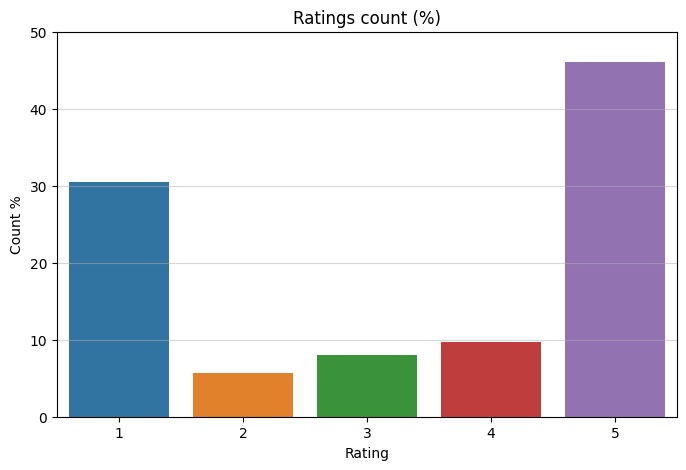

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(data = raw_data, x='rating', y='rating', estimator=lambda x: len(x) / len(raw_data) * 100)
plt.ylabel('Count %')
plt.xlabel('Rating')
plt.ylim(0,50)
plt.grid(axis='y', alpha=.5)
plt.title('Ratings count (%)')
plt.show()

The rating is mainly distributed to 1 and 5 with ~30% and ~47%. Both combined accounted for ~77% of the data. As we are doing binary classification, we can proceed with class 1 and 5 as negative and positve respectively. Otherwise we can include 2 as negative and 4 as positive as well to improve the model. We can do multi-class classification with 3 as neutral but we do not have a lot of samples in the data.

It is common that reviews are misclassified such as one star reviews treated as five star. Usually on Google Play Store and App Store, this entries are errors from reviewers. Unfortunately, identifying them in earlier phase is not possible unless you use pre-trained models to classify the sentiment. However, this defeat the purpose of building a sentiment analysis model. As an alternative, we can do residual/error analysis to observe the misclassified reviews.

One other common thing is typos in reviews as we can see immediately when reading the data (very god == very good). We may need to handle this for improving model's performance.

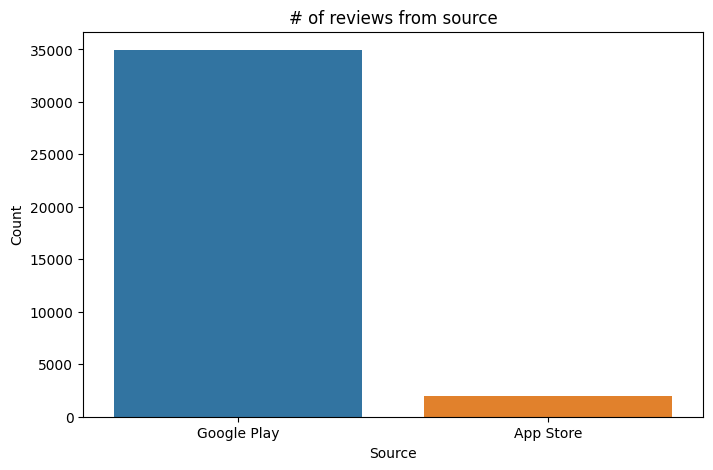

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(data = raw_data, x='source')
plt.ylabel('Count')
plt.xlabel('Source')
plt.title('# of reviews from source')
plt.show()

The reviews are mainly collected from Google Play Store, this might affect on user experience.

In [13]:
min_r = min(raw_data.review_date)
max_r = max(raw_data.review_date) 
print('The earliest review: {}, The latest review: {}'.format(min_r, max_r))

The earliest review: 2023-07-05, The latest review: 2023-08-07


Thread was launched on 5th July 2023 which corresponds to the earliest date above. The latest review is recorded in 7th August 2023, so there is one month span of review.

# 3. Dealing with Text (Preprocessing)

## Contractions, Punctuations, Stopwords, Lemmatize
- Contractions are words that are shorten with punctuations such as can't, don't, won't, etc. So we are going to convert those words.
- Punctuations do not give meaningful context so we are going to remove them. However it is important that we remove punctuations that are actual punctuations rather than contractions.
- Stopwords do not give meaningful context to sentiment so we are going to remove them. 
- Lemmatizing stem words into its root but preserve the meaning/context.

### Preprocessing Functions

In [14]:
stop_words = set(stopwords.words('english'))
translator=str.maketrans('','',string.punctuation)

def fix_contractions(review):
    """
    args
    review: string review to remove the contractions from
    return
    string review without contractions.
    """  
    assert isinstance(review,str), "text is not in string type"
    token = contractions.fix(review)
    
    return token

def remove_puncts(review):
    """
    args
    review: string review to remove the punctuations from
    return
    string review without punctuations.
    """  
    assert isinstance(review,str), "text is not in string type"
    token = review.translate(translator)
    
    return token
    
def remove_stopwords(review):
    """
    args
    review: string review to remove the stopwords from
    return
    string review without stopwords and lowercase the words.
    """    
    assert isinstance(review,str), "text is not in string type"
    tokens = word_tokenize(review)
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
        
    return ' '.join(tokens)

lemmatizer = WordNetLemmatizer()
def lemmatize(review):
    """
    args
    review: string review to remove the stopwords from
    return
    string review with words lemmatized
    """       
    assert isinstance(review,str), "text is not in string type"
    tokens = word_tokenize(review)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
        
    return ' '.join(tokens)

In [15]:
def preprocess(df):
    """
    preprocess the reviews based on functions above in order.
    args
    df: dataframe for text to be preprocessed
    return
    dataframe with text preprocessed
    """   
    data = df.copy()
    data['preprocess_text'] = data['review_description'].apply(lambda x: fix_contractions(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: remove_puncts(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: remove_stopwords(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: lemmatize(x))
    
    return data

In [16]:
time = datetime.now()
data_preproc = preprocess(raw_data)
print("Executed in",str(datetime.now() - time)[-12:-7])
data_preproc.head()

Executed in 00:11


,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,preprocess_text
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07,good
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07,weak copy twitter
2,Google Play,91ef61ce-0f05-4f3b-b3d3-5d19cd408ab8,SITI NUR HAFIZA BINTI AZIZ,NaN,i wish threads have a save button for images a...,3,0.0,2023-08-07,wish thread save button image video would like...
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07,love
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07,god


# 4. Dealing with the labels
We have ratings ranging from 1 to 5 and decided to only keep 1 and 5. We need to convert this to 0 for negative and 1 for positive. So 1 rating is encoded as 0 and 5 rating is encoded as 1. Later on, we can experiment on including 2 and 4 star for either multiclass or including them as negative/positive class.

In [17]:
model_data = data_preproc.loc[data_preproc.rating.isin([1,5])]
print('There are {} rows and {} columns, {} rows were removed (~{:.2f}% of data)'.format(
    model_data.shape[0], model_data.shape[1], 
    raw_data.shape[0]-model_data.shape[0],
    (raw_data.shape[0]-model_data.shape[0])/raw_data.shape[0]*100
    ))
model_data.head()

There are 28279 rows and 9 columns, 8660 rows were removed (~23.44% of data)


,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,preprocess_text
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,5,0.0,2023-08-07,good
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,1,0.0,2023-08-07,weak copy twitter
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,5,0.0,2023-08-07,love
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,5,0.0,2023-08-07,god
5,Google Play,950acab8-bc92-4e1e-81c4-3f228ccc7362,Samim Khan,NaN,Nice,1,0.0,2023-08-07,nice


In [18]:
model_data.rating = model_data.rating // 5 # this converts 5 into 1 and 1 into 0
model_data.rating

C:\Users\Brian\AppData\Local\Temp\ipykernel_2408\1987144868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.rating = model_data.rating // 5 # this converts 5 into 1 and 1 into 0


0        1
1        0
3        1
4        1
5        0
        ..
36936    1
36937    1
36939    1
36940    1
36941    0
Name: rating, Length: 28279, dtype: int64

# 5. Establishing Base Model
I am planning to do residual analysis on the model to improve the preprocessing stage. At this stage, it might be time-consuming to identify words that are for example, abbreviated, not in english, typos, etc. We can fix this by analysing the error made by the model and continously improve it.

## a. Splitting Data
I am going to split the data by 70% training, 20% validation, and 10% test set. Splitting is done by shuffling randomly on the preprocessed sentences.

In [130]:
def split_data(df):
    """
    args
    df: dataframe containing preprocessed text and labels to be splitted
    return
    train_sents, train_labels, val_sents, val_labels, test_sents, test_labels: 6 variables for each train, validation, test
    """
    data = df.sample(frac=1, random_state=77)
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.9)
    
    sentences = data['preprocess_text'].to_numpy()
    labels = data['rating'].to_numpy()
    
    train_sents = sentences[:train_size]
    val_sents = sentences[train_size:val_size]
    test_sents = sentences[val_size:]
    
    train_labels = labels[:train_size]
    val_labels = labels[train_size:val_size]
    test_labels = labels[val_size:]
    
    return train_sents, train_labels, val_sents, val_labels, test_sents, test_labels

In [20]:
train_sents, train_labels, val_sents, val_labels, test_sents, test_labels = split_data(model_data)
train_sents

array(['😍👍', 'boring', 'already say thread end better twitter', ...,
       'hate impose people decide delete account deletes instagram well',
       'copy product', 'намного лучше чем twitter'], dtype=object)

In [21]:
train_labels

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [22]:
length = len(max(train_sents, key=len).split())
print("The maximum length of sentence in training set is", length)

The maximum length of sentence in training set is 122


We can see from the example of reviews above that some words are not in English, are abbreviated, emojis. We may still discover some variations of this when we establish a base model. At current stage, I am just going to build a simple model with little to no hyperparameter tuning.

## b. Preprocessing Inputs
There are some steps we need to take before training the model with data. First is to preprocess it by tokenizing words and generating paddings.

In [23]:
OOV_TOKEN = "<OOV>"
NUM_WORDS = 1000
MAX_LEN = 122
EMB_DIM = 16

def tokenize(train_sentences, oov_token=OOV_TOKEN, num_words=NUM_WORDS):
    """
    Tokenize the list of strings ignoring punctuations, emojis
    args
    train_sentences: The sentences from training set
    oov_token: Out of Vocabulary token symbol
    num_words: Number of words to keep when tokenizing
    return
    Tokenizer object containing the word-index dictionary that has been fitted on training sentences
    """
    tokenizer = Tokenizer(oov_token=oov_token, num_words=num_words)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

def generate_seq_and_pad(sentences, tokenizer, max_len=MAX_LEN):
    """
    Tokenize the list of strings ignoring punctuations, emojis
    args
    sentences: The sentences to be converted into sequences
    tokenizer: Tokenizer object that has been fitted
    maxlen: Maxmimum length of sentence used for padding
    return
    padded sequences with same length as maxlen
    """   
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_seqs = pad_sequences(sequences, maxlen=max_len)
    
    return padded_seqs

In [24]:
tokenizer = tokenize(train_sents)
word_index = tokenizer.word_index
print("Vocabulary contains {} words".format(len(word_index)))

Vocabulary contains 15041 words


In [25]:
train_seq = generate_seq_and_pad(train_sents, tokenizer)
val_seq = generate_seq_and_pad(val_sents, tokenizer)
test_seq = generate_seq_and_pad(test_sents, tokenizer)

print("Padded training sequences have shape:", train_seq.shape)
print("Padded validation sequences have shape:", val_seq.shape)
print("Padded test sequences have shape:", test_seq.shape)

Padded training sequences have shape: (19795, 122)
Padded validation sequences have shape: (5656, 122)
Padded test sequences have shape: (2828, 122)


## c. Creating Base Model

In [26]:
def plot_metric(history, metric):
    plt.figure(figsize=(5,3))
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

In [27]:
tf.random.set_seed(77)

In [28]:
tf.keras.backend.clear_session()

with tf.device('/CPU:0'):
    base_model = tf.keras.models.Sequential([
        tfl.Embedding(NUM_WORDS, EMB_DIM, input_length=MAX_LEN),
        tfl.GlobalAveragePooling1D(),
        tfl.Dense(1, activation='sigmoid')
    ])
    
    EPOCHS = 50
    base_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy']
                      )
    history = base_model.fit(train_seq, train_labels, epochs=EPOCHS, validation_data=(val_seq, val_labels))

Epoch 1/50
619/619 [==============================] - 2s 3ms/step - loss: 0.6654 - accuracy: 0.5976 - val_loss: 0.6485 - val_accuracy: 0.6176
Epoch 2/50
619/619 [==============================] - 1s 2ms/step - loss: 0.6344 - accuracy: 0.6297 - val_loss: 0.6077 - val_accuracy: 0.6678
Epoch 3/50
619/619 [==============================] - 1s 2ms/step - loss: 0.5883 - accuracy: 0.6830 - val_loss: 0.5576 - val_accuracy: 0.7153
Epoch 4/50
619/619 [==============================] - 2s 4ms/step - loss: 0.5373 - accuracy: 0.7313 - val_loss: 0.5069 - val_accuracy: 0.7491
Epoch 5/50
619/619 [==============================] - 3s 5ms/step - loss: 0.4896 - accuracy: 0.7770 - val_loss: 0.4627 - val_accuracy: 0.7854
Epoch 6/50
619/619 [==============================] - 3s 5ms/step - loss: 0.4492 - accuracy: 0.8121 - val_loss: 0.4279 - val_accuracy: 0.8287
Epoch 7/50
619/619 [==============================] - 3s 5ms/step - loss: 0.4183 - accuracy: 0.8351 - val_loss: 0.4029 - val_accuracy: 0.8481
Epoch 

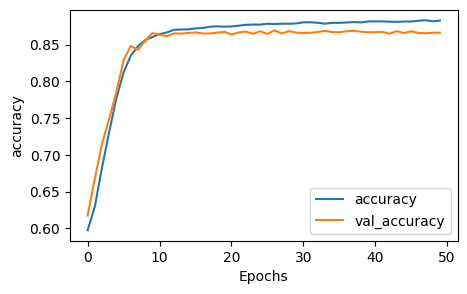

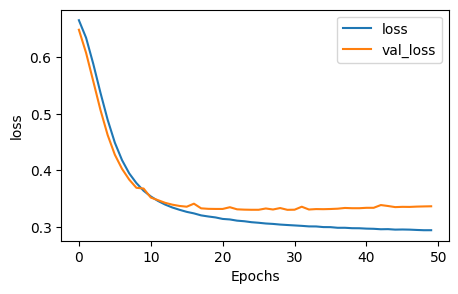

In [29]:
plot_metric(history, "accuracy")
plot_metric(history, "loss")

Accuracy on training set and validation set is around ~88% and ~86% respectively.

In [30]:
test_loss, test_acc = base_model.evaluate(test_seq, test_labels)
print("Loss on test set: {}\nAccuracy on test set: {}".format(test_loss, test_acc))

89/89 [==============================] - 2s 12ms/step - loss: 0.3408 - accuracy: 0.8667
Loss on test set: 0.34084048867225647
Accuracy on test set: 0.8666902184486389


# 6. Residual Analysis
For now I am going to analyse the errors made on the training set before going to the validation or test set.

In [31]:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [32]:
def make_residual_df(model, original_description, sentences, labels, sequences):
    """
    args
    model: the model that is going to used for predicting sequences
    original_description: the original review description from raw data
    sentences: the review description that has been preprocessed (has to be either the train, val, or test set)
    labels: the true labels of sentences (has to be either the train, val, or test set)
    sequences: the input to model that has been preprocessed (has to be either the train, val, or test set)
    
    return - dataframe containing residuals with original and preprocessed review, true label, and predicted label.
    """
    y_hat = (model.predict(sequences)>0.5).astype(int).ravel()
    incorrect_idxs = [i for i in range(len(y_hat)) if y_hat[i]!=labels[i]]
    print("There are {} incorrect predictions".format(len(incorrect_idxs)))

    ori_desc = [original_description[i] for i in incorrect_idxs]
    inc_reviews = [sentences[i] for i in incorrect_idxs]
    true_labels = [labels[i] for i in incorrect_idxs]
    pred_labels = [y_hat[i] for i in incorrect_idxs]

    resid = pd.DataFrame(zip(ori_desc, inc_reviews, true_labels, pred_labels), 
                     columns=['original_review','preproc_review', 'true_label', 'pred_label'])

    return resid

In [33]:
# original review description
data = model_data.sample(frac=1, random_state=77) # keeping same data that was sampled
ori_desc = data['review_description'].to_numpy()

In [34]:
resid_df = make_residual_df(base_model, ori_desc, train_sents, train_labels, train_seq)
with pd.option_context('display.min_rows', 20):
    display(resid_df.head(20))

619/619 [==============================] - 4s 6ms/step
There are 2329 incorrect predictions


,original_review,preproc_review,true_label,pred_label
0,"Not so long ago, there was a great instagram a...",long ago great instagram app called thread lik...,0,1
1,Time vest,time vest,0,1
2,Not bad,bad,1,0
3,Zuck is a cuck,zuck cuck,0,1
4,The app is still bugging out i don't know why ...,app still bugging know read bro,0,1
5,Anything to destroy Twitter,anything destroy twitter,1,0
6,💯🔥🔥💥,💯🔥🔥💥,0,1
7,Please make this app exact clone of Twitter th...,please make app exact clone twitter convenient...,0,1
8,How can you connect with mutuals without dms,connect mutuals without dm,0,1
9,No chat no cool,chat cool,0,1


Above are examples of incorrect predictions. Insights from the incorrect predictions:
-  Emojis may have low samples and may need to be investigated.
-  Adding stemming words to the preprocessing may be worth investigating.
-  We can see that `No`, `Not` gives meaningful context in above example so we may add this to custom dictionary.
-  Twitter seems to be impactful in determining sentiments on this data.
-  Some reviews lose its context when stopwords are removed.

## a. Adding more functions
Steps:
- Include `no` and `not` so it is not removed from stopwords.
- Include reviews that include `+` and `-` followed by a character either before or after such as `A++` or `-5`.
- For emojis, I am going to see if there are many samples using them.

In [35]:
# removing 'no' and 'not' from stopwords
stop_words.remove('no')
stop_words.remove('not')

In [36]:
# add stemming
# ps = PorterStemmer()
# def stem_words(review):
#     """
#     args
#     review: string review to be stemmed
#     return
#     string review after stemming.
#     """  
#     assert isinstance(review,str), "text is not in string type"
#     tokens = word_tokenize(review)
#     tokens = [ps.stem(token) for token in tokens]
    
#     return ' '.join(tokens)

In [37]:
import re
translator=str.maketrans('','',string.punctuation)

def remove_puncts(review):
    """
    Removes punctuations but keep instances such as '-5', '+10', '5+', 'A+', 'A-'
    args
    review: string review to remove the punctuations from
    return
    string review without punctuations.
    """  
    assert isinstance(review,str), "text is not in string type"
    pattern1 = r"(?i)(10?|[2-9])(?<![^ ]).(?<=[+])(?![^ ])|([A-D]).(?<=[+-])(?![a-z])"
    pattern2 = r"(?i)(?=[+-])(?<![a-z]|[1-9]).(10?|[2-9])(?![a-z])"
    match_str = []
    add_str = ''
    
    try:
        match_str += [s.group() for s in re.finditer(pattern1, review)]
        match_str += [s.group() for s in re.finditer(pattern2, review)]
    except:
        pass
        
    if len(match_str)>0:
        for i in range(len(match_str)):
            review = review.replace(match_str[i], '').strip()
            add_str += match_str[i] + ' '
            
    token = (add_str+review.translate(translator)).strip()
    
    return token

## b. Emoji and Non-English Characters

In [38]:
# add Spacy Emoji NLP object
import spacy
from spacymoji import Emoji
nlp_spacymoji = spacy.load("en_core_web_sm")
nlp_spacymoji.add_pipe('emoji', first=True)

In [39]:
import emoji
count = 0
for sent in resid_df['original_review'].to_numpy():
    tokens = [token.text for token in nlp_spacymoji(sent)]
    for token in tokens:
        if emoji.is_emoji(token):
            count += 1
            break
print(f'There are {count} reviews that have emojis incorrectly predicted')

There are 467 reviews that have emojis incorrectly predicted


So there are many reviews with emojis but the model failed to predict them. These emojis may be under-represented in the data, so tuning model may improve it. Alternatively, we could use external dataset to boost the samples.

Next, we are going to remove non-english words from the corpus. 

In [57]:
from nltk.corpus import words
eng_words = words.words()
def check_english_words(review):
    """
    This removes non-english characters except emojis
    args
    review: string review to check for english characters and emojis.
    return
    string review with only english words and emojis.
    """
    assert isinstance(review,str), "text is not in string type"
    # skip checking if all characters are ascii
    try:
        review.encode('ascii')
        return review
    # else check for emojis
    except:
        tokens = [token.text for token in nlp_spacymoji(review)]
        result = []
        for token in tokens:
            if not token.isascii():
                if emoji.is_emoji(token):
                    result.append(token)
                else:
                    word = ''.join([i if ord(i) < 128 else '' for i in token]) # remove non-ascii characters
                    if word.lower() in eng_words:
                        result.append(word) # only append if token is in english after removing non-ascii characters
            else:
                result.append(token)
    
        return ' '.join(result)

Let's rework the preprocess step.

In [58]:
def preprocess(df):
    """
    preprocess the reviews based on functions above in order.
    args
    df: dataframe for text to be preprocessed
    return
    dataframe with text preprocessed
    """   
    data = df.copy()
    data['preprocess_text'] = data['review_description'].apply(lambda x: fix_contractions(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: remove_puncts(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: check_english_words(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: remove_stopwords(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: lemmatize(x))
    
    return data

In [59]:
time = datetime.now()
data_preproc2 = preprocess(model_data)
print("Executed in",str(datetime.now() - time)[-12:-7])
data_preproc2.head()

Executed in 01:59


,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,preprocess_text
0,Google Play,7cd90e5b-4829-43b9-9fb4-c8c6d1e339c1,Eddie Clark Jr.,NaN,Good,1,0.0,2023-08-07,good
1,Google Play,6deb8265-2bac-4524-bcb6-f90829fa4e69,Rasa RT,NaN,Weak copy of Twitter,0,0.0,2023-08-07,weak copy twitter
3,Google Play,b7721b78-6b77-4f8c-a1d3-a854af4c1f0f,Asap Khalifah,NaN,Love it,1,0.0,2023-08-07,love
4,Google Play,c89ef522-c94c-4171-878f-1d672dce7f11,Syed Hussein,NaN,Very god,1,0.0,2023-08-07,god
5,Google Play,950acab8-bc92-4e1e-81c4-3f228ccc7362,Samim Khan,NaN,Nice,0,0.0,2023-08-07,nice


## c. Handling empty review

In [60]:
data_preproc2.loc[data_preproc2.preprocess_text=='']

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,preprocess_text
12,Google Play,2874e126-19f2-4e4e-88da-591be1a8978f,مهووسة ييهيون,NaN,بجربه,1,0.0,2023-08-07,
93,Google Play,61cd38ea-6c34-4886-8def-a6360b8b11dc,Safdar Freedi,NaN,کخ کخ,0,0.0,2023-08-06,
122,Google Play,b1a5d4f4-97ec-419c-affb-795b083ac997,Facebook Service,NaN,خمسة نجوم اتمناا ان يكون التطبيق جيدااا,1,0.0,2023-08-06,
133,Google Play,0d66ae6d-e887-4e29-8d93-8c5a487e4dad,Alireza Mohammadi,NaN,در هر صورت مثل توییتر گیج کننده است,1,0.0,2023-08-06,
157,Google Play,a9ddf0dd-c3b6-464b-83c0-08f4e0258d50,Kumkum Rai,NaN,स्टाग्राम डाउनलोड नहीं करना ना ता पागल हो जाएगा,1,0.0,2023-08-06,
...,...,...,...,...,...,...,...,...,...
34760,Google Play,50d37efb-0b71-47fa-a73a-640e2346dc5a,MOHAMMAD,NaN,خوبه,1,0.0,2023-07-06,
34823,Google Play,7f050114-0302-451f-a645-431e53467609,Mohffyy,NaN,مدري ليه,1,0.0,2023-07-06,
36299,App Store,d16768ea-bb8c-499c-9f1c-3622704e30f7,haiausue,I have a good time today,He is doing,1,NaN,2023-08-04,
36486,App Store,11886cf2-8b8e-437b-8de1-ea1df1944a9a,Clark Weston Jr.,Perfect just the way it is,.,1,NaN,2023-07-22,


We are going to remove empty review description due to non-english words. Here, I also found out that the description actually is located in the title. Combining the review title with the review description might help in this case. Also notice that the preprocessed text contain non-meaningful word or even only consist of a character.

In [61]:
# combining review title and review description
data_aug = model_data.copy()[['review_title', 'review_description', 'rating']]
data_aug.fillna('', inplace=True)
data_aug['comb_desc'] = (data_aug.review_title + ' ' + data_aug.review_description).str.strip()
with pd.option_context('display.min_rows', 20):
    display(data_aug.sample(10, random_state=55))

,review_title,review_description,rating,comb_desc
35611,This app has birthed me into a new person,"My skin is clear, my debts are gone, my divorc...",1,This app has birthed me into a new person My s...
24301,,I love Threads.,1,I love Threads.
969,,He is prafeta App 👍👍👍,0,He is prafeta App 👍👍👍
22616,,It's lagging 🤒,0,It's lagging 🤒
26389,,Mike Tel,1,Mike Tel
4873,,This app is actually really good,1,This app is actually really good
9216,,What an app just waste of time no sense of usi...,0,What an app just waste of time no sense of usi...
34721,,تطبيق يجنن,1,تطبيق يجنن
2981,,Blue tick,1,Blue tick
16644,,"The king is dead, long live the king.",1,"The king is dead, long live the king."


In [62]:
with pd.option_context('display.min_rows', 20):
    display(data_aug.loc[(data_aug.review_title!='') & ((data_aug.review_description.str.len())<15)].head(20))

,review_title,review_description,rating,comb_desc
36299,I have a good time today,He is doing,1,I have a good time today He is doing
36486,Perfect just the way it is,.,1,Perfect just the way it is .
36609,Instagram with text…,Works for me!,1,Instagram with text… Works for me!
36837,Please add a pinned thread option 🙏🏻,See above,1,Please add a pinned thread option 🙏🏻 See above
36845,Elon isn’t in it,10/10,1,Elon isn’t in it 10/10
36905,Anything is better then twitter,Lol,1,Anything is better then twitter Lol
36933,New social media dropped !,Fire Ong,1,New social media dropped ! Fire Ong
36936,Better Than Twitter,…,1,Better Than Twitter …
36940,Let the battle begin!,😂😂😂,1,Let the battle begin! 😂😂😂


Some people made their review on the review title, so the review description may have little to no context. When combined, the review gives more meaning to sentiment, rather than having just punctuations or emojis. We are going to rework the preprocess function for a bit.

In [63]:
def preprocess(df, column):
    """
    preprocess the reviews based on functions above in order.
    args
    df: dataframe for text to be preprocessed
    column: column name (str) to be preprocessed
    return
    dataframe with text preprocessed
    """   
    data = df.copy()
    data['preprocess_text'] = data[column].apply(lambda x: fix_contractions(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: remove_puncts(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: check_english_words(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: remove_stopwords(x))
    data['preprocess_text'] = data['preprocess_text'].apply(lambda x: lemmatize(x))
    
    return data

Now we have column as an added parameter to transform the combined review.

In [64]:
time = datetime.now()
data_preproc3 = preprocess(data_aug, 'comb_desc')
print("Executed in",str(datetime.now() - time)[-12:-7])
data_preproc3.head()

Executed in 01:58


,review_title,review_description,rating,comb_desc,preprocess_text
0,,Good,1,Good,good
1,,Weak copy of Twitter,0,Weak copy of Twitter,weak copy twitter
3,,Love it,1,Love it,love
4,,Very god,1,Very god,god
5,,Nice,0,Nice,nice


In [65]:
with pd.option_context('display.min_rows', 50):
    display(data_preproc3.loc[data_preproc3.preprocess_text==''].tail(50))

,review_title,review_description,rating,comb_desc,preprocess_text
31309,,طرش طرش,1,طرش طرش,
31489,,एप्लिकेशन बहुत लेग कर रही ह पूरा पेज हिलने लगता ह,0,एप्लिकेशन बहुत लेग कर रही ह पूरा पेज हिलने लगता ह,
31532,,Güzelebenziyo,1,Güzelebenziyo,
31613,,لا إلاه إلا الله محمد رسول الله,0,لا إلاه إلا الله محمد رسول الله,
31625,,یعنی چی نمیتونیم تو ایران استفاده کنیم,0,یعنی چی نمیتونیم تو ایران استفاده کنیم,
31710,,হ্যালো বন্ধু তোমরা সবাই কেমন আছো ঠিক আছে কি খব...,1,হ্যালো বন্ধু তোমরা সবাই কেমন আছো ঠিক আছে কি খব...,
32098,,عسسسل,1,عسسسل,
32173,,very niçe àpp,1,very niçe àpp,
32215,,বাংলাদেশের কেকে?,1,বাংলাদেশের কেকে?,
32235,,ᵀʰᵉ ᵇᵉˢʳ,1,ᵀʰᵉ ᵇᵉˢʳ,


Most of the reviews above are written in non-ascii with some a combination of non-ascii and ascii that results in a proper english word. We are going to remove empty preprocessed review.

In [66]:
print(len(data_preproc3.loc[data_preproc3.preprocess_text=='']))

449


In [76]:
data_preproc3 = data_preproc3.loc[data_preproc3.preprocess_text!='']

# 7. Back to Model

In [87]:
train_sents, train_labels, val_sents, val_labels, test_sents, test_labels = split_data(data_preproc3)
train_sents

array(['logo look like tamizh word',
       'issue upload picture glitch 😕 update aap resolve problem thread would 5587922',
       'great app always wanted stop using twitter finally found better substitute',
       ...,
       'point facebook already bend authoritarian corrupt regime like turkey iran qatar etc',
       'love', '❤️'], dtype=object)

In [88]:
length = len(max(train_sents, key=len).split())
print("The maximum length of sentence in training set is", length)

The maximum length of sentence in training set is 138


In [108]:
MAX_LEN = 138
NUM_WORDS = 2000
tokenizer = tokenize(train_sents, num_words=NUM_WORDS)
word_index = tokenizer.word_index
print("Vocabulary contains {} words".format(len(word_index)))

Vocabulary contains 11829 words


In [109]:
train_seq = generate_seq_and_pad(train_sents, tokenizer, MAX_LEN)
val_seq = generate_seq_and_pad(val_sents, tokenizer, MAX_LEN)
test_seq = generate_seq_and_pad(test_sents, tokenizer, MAX_LEN)

print("Padded training sequences have shape:", train_seq.shape)
print("Padded validation sequences have shape:", val_seq.shape)
print("Padded test sequences have shape:", test_seq.shape)

Padded training sequences have shape: (19481, 138)
Padded validation sequences have shape: (5566, 138)
Padded test sequences have shape: (2783, 138)


In [110]:
tf.keras.backend.clear_session()
from keras import regularizers

with tf.device('/CPU:0'):
    model2 = tf.keras.models.Sequential([
        tfl.Embedding(NUM_WORDS, 20, input_length=MAX_LEN),
        # tfl.SimpleRNN(16, return_sequences=True,),
        tfl.Conv1D(16, 3, activation='relu'),
        tfl.MaxPooling1D(),
        tfl.Dropout(0.2),
        tfl.GlobalMaxPooling1D(),
        tfl.Dense(12, activation='relu', kernel_regularizer=regularizers.L2(1e-7)),
        tfl.Dense(1, activation='sigmoid')
    ])

    early_stop = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    min_delta=0,
                    patience=15,
                    verbose=1,
                    mode='min',
                    baseline=.3,
                    restore_best_weights=True,
                )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    0.01,
                    decay_steps=50,
                    decay_rate=0.95,
                    staircase=True
                )
    
    EPOCHS = 50
    model2.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                       metrics=['accuracy']
                      )
    history = model2.fit(train_seq, train_labels, epochs=EPOCHS, validation_data=(val_seq, val_labels), callbacks=[early_stop])

Epoch 1/50
609/609 [==============================] - 14s 20ms/step - loss: 0.3045 - accuracy: 0.8727 - val_loss: 0.2635 - val_accuracy: 0.8960
Epoch 2/50
609/609 [==============================] - 12s 19ms/step - loss: 0.2127 - accuracy: 0.9187 - val_loss: 0.2593 - val_accuracy: 0.8965
Epoch 3/50
609/609 [==============================] - 9s 14ms/step - loss: 0.1793 - accuracy: 0.9352 - val_loss: 0.2632 - val_accuracy: 0.8969
Epoch 4/50
609/609 [==============================] - 4s 7ms/step - loss: 0.1617 - accuracy: 0.9423 - val_loss: 0.2729 - val_accuracy: 0.8985
Epoch 5/50
609/609 [==============================] - 4s 6ms/step - loss: 0.1497 - accuracy: 0.9476 - val_loss: 0.2743 - val_accuracy: 0.9008
Epoch 6/50
609/609 [==============================] - 3s 6ms/step - loss: 0.1442 - accuracy: 0.9506 - val_loss: 0.2777 - val_accuracy: 0.8996
Epoch 7/50
609/609 [==============================] - 3s 6ms/step - loss: 0.1415 - accuracy: 0.9516 - val_loss: 0.2807 - val_accuracy: 0.8978
E

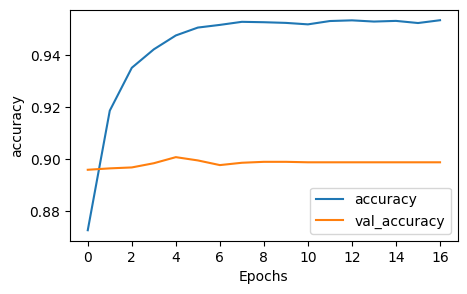

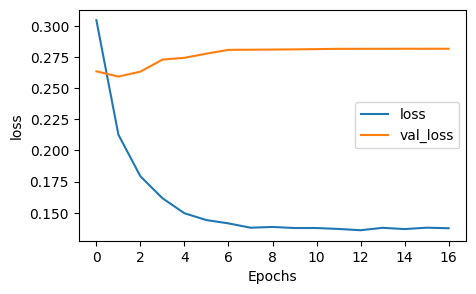

In [111]:
plot_metric(history, "accuracy")
plot_metric(history, "loss")

Version:  
1 - When using RNN, the model overfits after 4 epochs with accuracy stagnant and loss increasing.  

2 - After regularization the model successfully prevented the validation loss from increasing, but still the accuracy is not even increasing after 2 epochs on validation set. Now it has ~94% accuracy on training set and ~89% on validation set. Let's further inspect on its error.

3 - Using `num_words=2000`, training accuracy hits ~95% and loss on validation is 0.2816.

In [116]:
test_loss, test_acc = model2.evaluate(test_seq, test_labels)
print("Loss on test set: {:.2f}\nAccuracy on test set: {:.2f}%".format(test_loss, test_acc*100))

87/87 [==============================] - 1s 8ms/step - loss: 0.2651 - accuracy: 0.8947
Loss on test set: 0.27
Accuracy on test set: 89.47%


In [121]:
data2 = data_preproc3.sample(frac=1, random_state=77) # keeping same random state
ori_desc2 = data2['review_description'].to_numpy()
resid_df = make_residual_df(model2, ori_desc2, train_sents, train_labels, train_seq)
with pd.option_context('display.min_rows', 20):
    display(resid_df.head(20))

609/609 [==============================] - 3s 5ms/step
There are 1143 incorrect predictions


,original_review,preproc_review,true_label,pred_label
0,Look like instagram.,look like instagram,0,1
1,"The feed was slick and easy to read, though fo...",feed slick easy read though populated largely ...,1,0
2,Twitter beatable,twitter beatable,1,0
3,Hashtag and DM are missing 🥴,hashtag dm missing 🥴,0,1
4,Twitter > Thread,twitter thread,1,0
5,Not bad,not bad,1,0
6,Very interesting application,interesting application,0,1
7,Where is dark them in this application,dark application,0,1
8,threads keeps stopping,thread keep stopping,0,1
9,Zukerb now extra data mil gayi tumko moj karo,zukerb extra data mil gayi tumko moj karo,1,0


In [131]:
val_size_out = int(len(ori_desc2) * 0.9)
resid_df_test = make_residual_df(model2, ori_desc2[val_size_out:], test_sents, test_labels, test_seq)
with pd.option_context('display.min_rows', 20):
    display(resid_df_test.head(20))

87/87 [==============================] - 1s 6ms/step
There are 293 incorrect predictions


,original_review,preproc_review,true_label,pred_label
0,Bkwas,bkwas,0,1
1,Why no post edit option??,no post edit option,1,0
2,If you login this app 5 later your account got...,login app 5 later account got hacked instagram,0,1
3,Bootleg Twitter,bootleg twitter,0,1
4,I love elon musk,love elon musk,0,1
5,I just want BTS & Seventeen on this app,want bts seventeen app,1,0
6,Aids,aid,0,1
7,Ldki hi ni mili,ldki hi ni mili,0,1
8,Os,o,0,1
9,Update your message,update message,0,1


In [151]:
inc_seqs = tokenizer.texts_to_sequences(resid_df_test['preproc_review'].values)

In [160]:
seqs_idxs = [i for i in range(len(inc_seqs)) if 1 in inc_seqs[i]]
print('Number of reviews with at least one OOV: {}, test samples: {}'.format(len(seqs_idxs), test_seq.shape[0]))

Number of reviews with at least one OOV: 164, test samples: 2783


In case of test samples, the incorrect predictions are mostly on review without meaningful context or gibberish. Some of them are also mislabeled or contain ambiguity. I think the word `why` or question marks is associated with negative sentiment in the situation of reviews.

# 8. Making Pipeline
This will make any text is preprocessed and can be inputted into the model for predictions.

In [ ]:
def pipeline(input_text):
    